In [1]:
# Youtube: https://www.youtube.com/watch?v=CogGIdkDA8g

In [2]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras

In [3]:
# Define constants
SEED = 909
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 40
IMAGE_WIDTH = 80
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = 'data/slices/'
data_dir_train = os.path.join(data_dir, 'training')
# The images should be stored under: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'img')
# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'img')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 360
NUM_TEST = 100

NUM_OF_EPOCHS = 100

In [4]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [5]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 150 images belonging to 1 classes.
Found 150 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


In [6]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [7]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

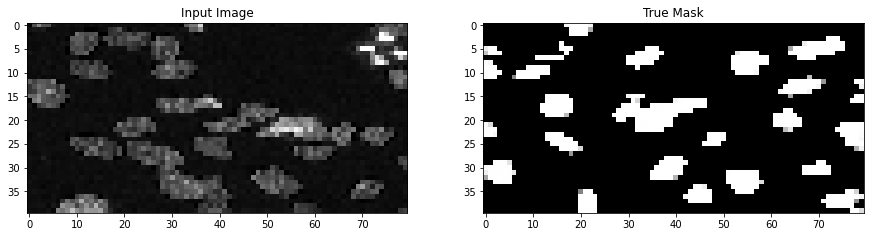

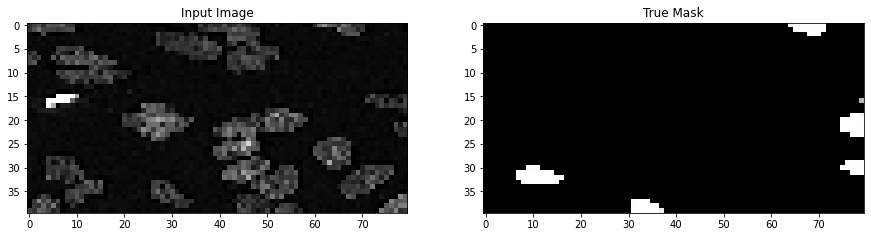

In [8]:
show_dataset(train_generator, 2)

In [9]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')
        

In [10]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 80, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 80, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 20, 40, 32)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [12]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS)

Epoch 1/100


/Users/taoxiang/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


11/11 [==============================] - 10s 793ms/step - loss: 0.6319 - accuracy: 0.7989 - val_loss: 0.5634 - val_accuracy: 0.8404
Epoch 2/100
11/11 [==============================] - 8s 753ms/step - loss: 0.4422 - accuracy: 0.8558 - val_loss: 0.4975 - val_accuracy: 0.8404
Epoch 3/100
11/11 [==============================] - 9s 791ms/step - loss: 0.4208 - accuracy: 0.8580 - val_loss: 0.4538 - val_accuracy: 0.8404
Epoch 4/100
11/11 [==============================] - 7s 663ms/step - loss: 0.4100 - accuracy: 0.8585 - val_loss: 0.4215 - val_accuracy: 0.8404
Epoch 5/100
11/11 [==============================] - 7s 663ms/step - loss: 0.4151 - accuracy: 0.8534 - val_loss: 0.4105 - val_accuracy: 0.8404
Epoch 6/100
11/11 [==============================] - 7s 654ms/step - loss: 0.4093 - accuracy: 0.8557 - val_loss: 0.4113 - val_accuracy: 0.8404
Epoch 7/100
11/11 [==============================] - 7s 662ms/step - loss: 0.4034 - accuracy: 0.8590 - val_loss: 0.4160 - val_accuracy: 0.8404
Epoch 8/10

In [13]:
model.save(f'UNET-ToothSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [14]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


In [15]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

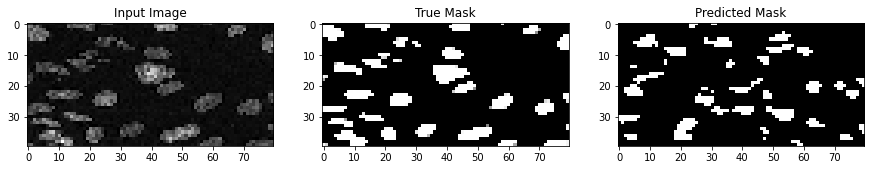

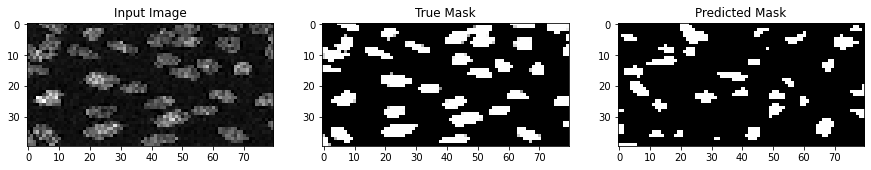

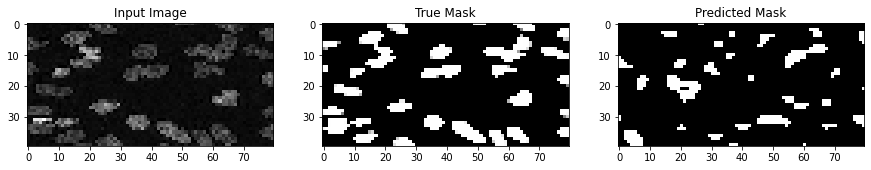

In [16]:
show_prediction(test_generator, 3)

In [17]:
# https://github.com/madsendennis/notebooks